---
format:
  html:
    code-line-numbers: true
    code-overflow: wrap
    code-block-bg: true
    code-block-border-left: true
    highlight-style: Arrow
---

# Capacitated Vehicle Routing Problem {#sec-ip-cvrp}

The Capacitated Vehicle Routing Problem (CVRP) is a classical combinatorial optimization problem that involves finding the optimal set of routes for a fleet of vehicles to deliver goods or services to a set of customers.
In the CVRP, a set of customers is given, each with a known demand and location. A fleet of vehicles, each with a limited capacity, is available to serve these customers.
The problem is to find a set of routes visited by the vehicles such that each customer is visited once and only once and the total traveling distance is minimized.

We use the notation provided in @toth_vehicle_2014 to facilitate the presentation of different CVRP models. The depot, denoted as 0, serves as the starting point for transporting goods to customers in $\mathcal{N} = {1, 2, \cdots, n}$ using a homogeneous fleet $\mathcal{K} = {1, 2, \cdots, |\mathcal{K}|}$. 
Each customer in $\mathcal{N}$ has a demand of $q_i \geq 0$, and each vehicle has a positive capacity of $Q > 0$. 
The cost of transportation, denoted by $c_{ij}$, is incurred when a vehicle travels between $i$ and $j$. 
A vehicle's route begins at the depot, visits some or all the customers in $\mathcal{N}$, and then returns to the depot. 
The objective is to determine the optimal set of routes for the fleet to minimize the total cost of transportation.

The CVRP could be defined on a directed graph $\mathcal{G} = (\mathcal{V}, \mathcal{A})$, where $\mathcal{V} = \{0\} \cup \{1, 2, \cdots, n\} = \{0, 1, \cdots, n\}$, and $\mathcal{A} = \{(i, j) | i, j \in \mathcal{V}, i \neq j\}$.
Let $S$ be a subset of $\mathcal{V}$, that is, $S \subseteq \mathcal{V}$.
The in-arcs and out-arcs of $S$ are defined as follows:

- $\delta^-(S) = \{(i, j) \in \mathcal{A} | i \notin S, j \in S \}$
- $\delta^+(S) = \{(i, j) \in \mathcal{A} | i \in S, j \notin S \}$

In addition, we use $\mathcal{A}(S) = \{(i, j) \in \mathcal{A} | i \in S, j \in S \}$ to indicate all the arcs that connect nodes within $S$.

## CVRP Instances

We use the instances taken from @cvrplib to illustrate the modeling and solving process with Google OR-Tools.
@cvrplib contains many benchmarking instances for CVRP and we use the python package `vrplib` to load the instance `P-n16-k8.vrp` and its optimal solution `P-n16-k8.sol`.

In [1]:
# install vrplib with command: pip install vrplib
import vrplib

# Read VRPLIB formatted instances (default)
instance = vrplib.read_instance("./data/cvrp/P-n16-k8.vrp")
solution = vrplib.read_solution("./data/cvrp/P-n16-k8.sol")

Let's first create a function to visualize vehicle routes, as given below.

In [2]:
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def show_vehicle_routes(locations, edges):
    """draw vehicles routings
    adapted from https://stackoverflow.com/a/50682819
    
    examples:
    locations = {
        0: (5, 5),
        1: (4, 9),
        2: (6, 4),
        3: (2, 6),
    }

    edges = [
        (0, 1, {'vehicle': '0'}),
        (1, 2, {'vehicle': '0'}),
        (2, 0, {'vehicle': '0'}),
        (0, 3, {'vehicle': '1'}),
        (3, 0, {'vehicle': '1'}),
    ]

    Args:
        locations (dict): location id -> (lat, lon)
        edges (list): list of edges
    """
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(15,10))
    
    vehicles = set([e[2]['vehicle'] for e in edges])
    num_vehicles = len(vehicles)
    
    colors = mpl.colormaps["Set1"].colors
    for v in range(num_vehicles):
        temp = [e for e in edges if e[2]['vehicle'] == str(v)]
        
        color_idx = v 
        if color_idx >= len(colors):
            color_idx = color_idx % len(colors)
        color = np.array([colors[color_idx]])
        
        nx.draw_networkx_nodes(G, 
                                locations, 
                                nodelist=[x[0] for x in temp], 
                                node_color=color)
        nx.draw_networkx_edges(G,
                                locations, 
                                edgelist=temp,
                                width=4, 
                                edge_color=color, 
                                style='dashed')

    #let's color the node 0 in black
    nx.draw_networkx_nodes(G, locations, 
                            nodelist=[0], 
                            node_color='k')

    # labels
    nx.draw_networkx_labels(G, locations, 
                            font_color='w', 
                            font_size=12, 
                            font_family='sans-serif')

    #print out the graph
    plt.axis('off')
    plt.show()

@fig-cvrp-p-n16-k6-sol shows the optimal vehicle routes for the instance P-n16-k8.vrp.

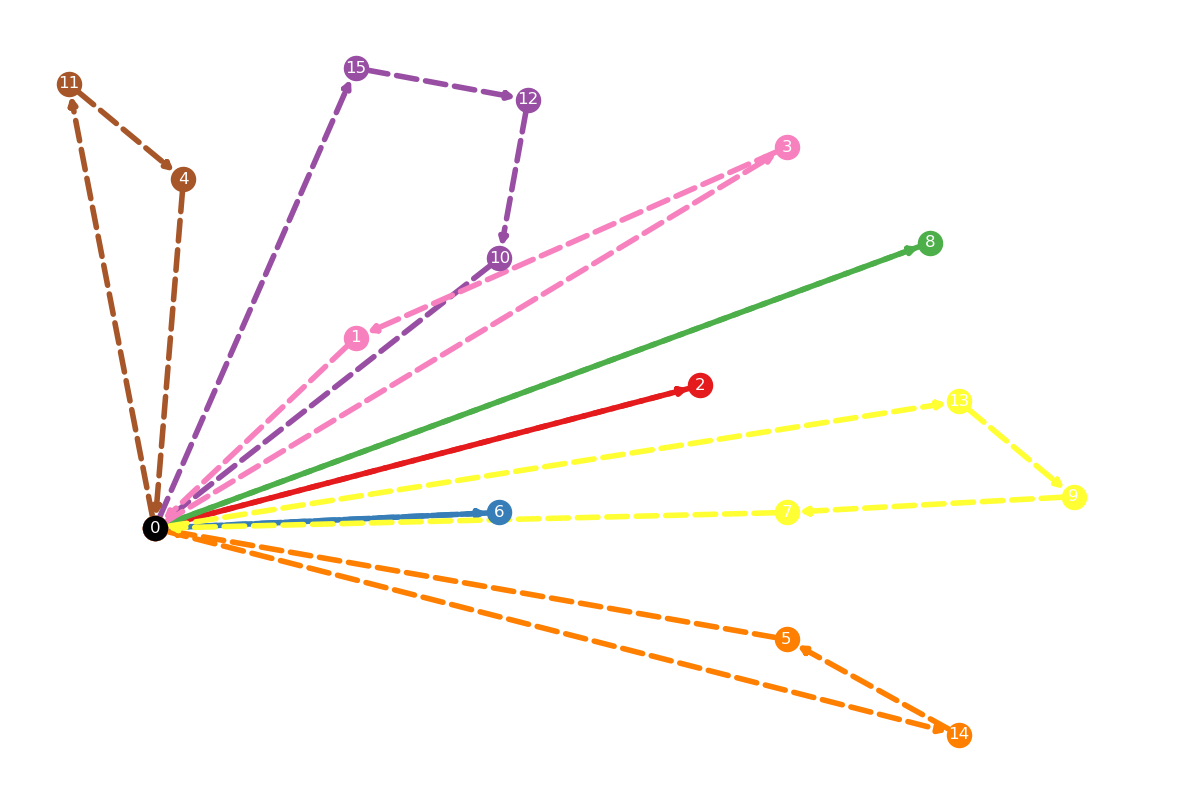

In [3]:
#| code-fold: true
#| label: fig-cvrp-p-n16-k6-sol
#| fig-cap: Optimal routes for instance P-n16-k8.vrp

# visualize the optimal solution
node_coords = instance['node_coord']
locations = {}
for idx, coord in enumerate(node_coords):
    locations[idx] = (coord[0], coord[1])

routes = solution['routes']
vehicle_idx = 0
edges = []
for route in routes:
    r_temp = route.copy()
    r_temp.insert(0, 0)
    r_temp.insert(len(r_temp), 0)
    for i in range(len(r_temp) - 1):
        edges.append((r_temp[i], r_temp[i + 1], {'vehicle': str(vehicle_idx)}))
    
    vehicle_idx += 1

show_vehicle_routes(locations, edges)

## Two-index Formulation - 1

This formulation was proposed by @laporte_exact_1986 and we present the formulation given in @toth_vehicle_2014.
In this formulation, we define the variable $x_{ij}$ that equals 1 if the arc $(i, j)$ is traversed by a vehicle.
The complete model is given below.

\begin{align}
    \text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{cvrp-two-index-obj} \\
    \text{s.t.} &\quad \sum_{j \in \delta^+(i)}x_{ij} = 1, \ \forall i \in \mathcal{N} \label
    {cvrp-two-index-cons1}\\
    &\quad \sum_{i \in \delta^-(j)} x_{ij} = 1, \ \forall j \in \mathcal{N} \label{cvrp-two-index-cons2} \\
    &\quad \sum_{j \in \delta^+(0)} x_{oj} = |\mathcal{K}| \label{cvrp-two-index-cons3} \\
    &\quad \sum_{(i, j) \in \delta^+(S)} x_{ij} \geq r(S), \ \forall S \subseteq \mathcal{N}, S \neq \emptyset \label{cvrp-two-index-cons4} \\
    &\quad x_{ij} \in \{0, 1\}, \ \forall (i, j) \in \mathcal{A} \label{cvrp-two-index-cons5}
\end{align}

The objective function represented by equation \eqref{cvrp-two-index-obj} is to minimize the overall transportation costs. The constraints expressed in equations \eqref{cvrp-two-index-cons1} and \eqref{cvrp-two-index-cons2} work together to guarantee that each customer is visited only once, with one incoming and outgoing arc. Constraints \eqref{cvrp-two-index-cons3} ensure that all available vehicles are utilized to serve the customers. Constraints \eqref{cvrp-two-index-cons4} prevent the formation of sub-tours. Finally, the variable types are defined by the last set of constraints, which are presented in equation \eqref{cvrp-two-index-cons5}.

To solve the aforementioned instance, we'll first prepare the data for our following implementation use.
Let's first define two classes, `Node` and `Vehicle`, to represent a node in the network and the vechiles, respectively.

In [120]:
class Node:
    """a node is either a depot (0) or a customer
    """
    
    def __init__(self, id, x_coord=0, y_coord=0, demand=0):
        self._id = id
        self._x_coord = x_coord
        self._y_coord = y_coord
        self._demand = demand
        
    @property
    def id(self): return self._id
    
    @property
    def x_coord(self): return self._x_coord
    
    @property
    def y_coord(self): return self._y_coord
    
    @property
    def demand(self): return self._demand
    
    def __str__(self):
        return f"id: {self._id},\
            x_coord: {self._x_coord},\
            y_coord: {self._y_coord},\
            demand: {self._demand}"

In [7]:
class Vehicle:
    """a vehicle
    """
    
    def __init__(self, id, capacity):
        self._id = id
        self._capacity = capacity
        
    @property
    def id(self): return self._id
    
    @property
    def capacity(self): return self._capacity
    
    def __str__(self):
        return f"id: {self._id}, capacity: {self._capacity}"

Now let's define a class `CvrpDataCenter` to hold all the information we need later.
It also has a helper function to read and parse a CVRP instance.

In [118]:
from typing import List
import vrplib
import re
from itertools import combinations

class CvrpDataCenter:
    """this class manages all the data for a CVRP instance
    """
    
    def __init__(self):
        self._nodes: List = None
        self._vehicles: List = None
        self._distance: List[List] = None

    def read_cvrp_instance(self, instance_file):
        """read a given cvrp instance

        Args:
            instance_file (str): instance file
        """
        instance = vrplib.read_instance(instance_file)

        # gather nodes
        nodes = []
        idx = 0
        if 'node_coord' in instance:
            for node, demand in zip(instance['node_coord'], 
                                    instance['demand']):
                node = Node(id=idx, 
                            x_coord=node[0], 
                            y_coord=node[1], 
                            demand=demand)
                idx += 1
                nodes.append(node)
        else:
            for demand in instance['demand']:
                node = Node(id=idx, 
                            demand=demand)
                idx += 1
                nodes.append(node)
            
        # gather vehicles
        comment = instance['comment']
        num_vehicles = int(re.search(r'\d', comment).group())
        vehicles = []
        for v in range(num_vehicles):
            vehicle = Vehicle(v, int(instance['capacity']))
            vehicles.append(vehicle)
        
        # gather distance matrix
        distance = instance['edge_weight']
        
        self._nodes = nodes
        self._vehicles = vehicles
        self._distance = distance
    
    @property
    def nodes(self): return self._nodes
    
    @property
    def vehicles(self): return self._vehicles
    
    @property
    def num_nodes(self): return len(self._nodes)
    
    @property
    def num_vehicles(self): return len(self._vehicles)
    
    @property
    def vehicle_capacity(self): 
        return self._vehicles[0].capacity

    def distance(self, i, j, integer=False):
        return round(self._distance[i][j]) \
            if integer else self._distance[i][j]
    
    def get_all_combinations(self, numbers):
        combs = []
        for i in range(1, len(numbers) + 1):
            combs.extend(list(combinations(numbers, i)))
        return combs

To implement this formulation using Google OR-Tools, we first create a `CvrpDataCenter` object and read in the instance `P-n16-k8.vrp`.
Then we create a `solver` object with solver option `SCIP` to solve mixed integer programming problems.

In [139]:
from ortools.linear_solver import pywraplp
import numpy as np
from itertools import product
import math

# prepare instance
cvrp_data_center = CvrpDataCenter()
cvrp_data_center.read_cvrp_instance("./data/cvrp/P-n16-k8-mini.vrp")

# instantiate solver
solver = pywraplp.Solver.CreateSolver('SCIP')

Now let's create the decision variable $x_{ij}$.
Note that we don't need to create variables when $i = j$ since there is no arc pointing to itself in the graph $\mathcal{G}$ we defined earlier.

In [142]:
# create decision variables
num_nodes = cvrp_data_center.num_nodes
num_vehicles = cvrp_data_center.num_vehicles
var_x = np.empty((num_nodes, num_nodes), dtype=object)
for i, j in product(range(num_nodes), range(num_nodes)):
    if i == j: continue
    var_x[i][j] = solver.BoolVar(name="x_{i, j}")

Then we create the objective function.

In [143]:
# define objective function
obj_expr = [
    cvrp_data_center.distance(i, j, integer=True) * var_x[i][j]
    for i, j in product(range(num_nodes), range(num_nodes))
    if i != j
]
solver.Minimize(solver.Sum(obj_expr))

And we create the constraints \eqref{cvrp-two-index-cons1} and \eqref{cvrp-two-index-cons2}.

In [145]:
# create incoming and outgoing arc constraints
for i in range(1, num_nodes):
    out_arcs = [var_x[i][j] for j in range(num_nodes) if j != i]
    in_arcs = [var_x[j][i] for j in range(num_nodes) if j != i]
    solver.Add(solver.Sum(out_arcs) == 1)
    solver.Add(solver.Sum(in_arcs) == 1)

Constraints \eqref{cvrp-two-index-cons3} are created as follows.

In [146]:
#| echo: true
#| output: false

# create fleet size constraint
expr = [var_x[0][i] for i in range(1, num_nodes)]
solver.Add(solver.Sum(expr) == num_vehicles)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x10ec3c9c0> >

\newcommand{\ceil}[1]{\lceil {#1} \rceil}

To create the subtour elimination constraints \eqref{cvrp-two-index-cons4}, we first need to enumerate all the non-empty subset of $\mathcal{N}$, for which we define a helper function named `get_all_combinations()` in the `CvrpDataCenter` class.
In the code snippet below, we define a separate constraint for every nonempty customer set $S$, and the right-hand side $r(S)$ is defined as $\ceil{q(S) / Q}$.

In [147]:
# create subtour elimination constraint
nodes = cvrp_data_center.nodes
vehicle_capacity = cvrp_data_center.vehicle_capacity
customer_ids = [node.id for node in nodes if node.id > 0]
node_ids = [node.id for node in nodes]
nonempty_customer_sets = cvrp_data_center.get_all_combinations(customer_ids)
for customer_set in nonempty_customer_sets:
    others = set(node_ids).difference(customer_set)
    expr = [var_x[i][j]
            for i in customer_set
            for j in others]
    total_demand = sum([node.demand 
                        for node in nodes 
                        if node.id in set(customer_set)])
    rhs = math.ceil(total_demand / vehicle_capacity)
    solver.Add(solver.Sum(expr) >= rhs)

Putting it all together, we have the complete program below.
It can be seen from the output that the optimal solution is 450 and there are 8 routes in the identified solution.

In [172]:
from ortools.linear_solver import pywraplp
import numpy as np
from itertools import product
import math

# prepare instance
cvrp_data_center = CvrpDataCenter()
cvrp_data_center.read_cvrp_instance("./data/cvrp/P-n16-k8-mini.vrp")

# instantiate solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create decision variables
num_nodes = cvrp_data_center.num_nodes
num_vehicles = cvrp_data_center.num_vehicles
var_x = np.empty((num_nodes, num_nodes), dtype=object)
for i, j in product(range(num_nodes), range(num_nodes)):
    if i == j: continue
    var_x[i][j] = solver.BoolVar(name="x_{i, j}")

# define objective function
obj_expr = [
    cvrp_data_center.distance(i, j, integer=True) * var_x[i][j]
    for i, j in product(range(num_nodes), range(num_nodes))
    if i != j
]
solver.Minimize(solver.Sum(obj_expr))

# create incoming and outgoing arc constraints
for i in range(1, num_nodes):
    out_arcs = [var_x[i][j] for j in range(num_nodes) if j != i]
    in_arcs = [var_x[j][i] for j in range(num_nodes) if j != i]
    solver.Add(solver.Sum(out_arcs) == 1)
    solver.Add(solver.Sum(in_arcs) == 1)

# create fleet size constraint
expr = [var_x[0][i] for i in range(1, num_nodes)]
solver.Add(solver.Sum(expr) == num_vehicles)

# create subtour elimination constraint
nodes = cvrp_data_center.nodes
vehicle_capacity = cvrp_data_center.vehicle_capacity
customer_ids = [node.id for node in nodes if node.id > 0]
node_ids = [node.id for node in nodes]
nonempty_customer_sets = cvrp_data_center.get_all_combinations(customer_ids)
for customer_set in nonempty_customer_sets:
    others = set(node_ids).difference(customer_set)
    expr = [var_x[i][j]
            for i in customer_set
            for j in others]
    total_demand = sum([node.demand 
                        for node in nodes 
                        if node.id in set(customer_set)])
    rhs = math.ceil(total_demand / vehicle_capacity)
    solver.Add(solver.Sum(expr) >= rhs)
    
status = solver.Solve()
if not status:
    opt_obj = solver.Objective().Value()
    
    opt_x = np.zeros((num_nodes, num_nodes))
    for i, j in product(range(num_nodes), range(num_nodes)):
        if i == j: continue
        opt_x[i][j] = int(var_x[i][j].solution_value())

    routes = []
    for i in range(1, num_nodes):
        if opt_x[0][i] == 0: continue
        # new route found
        route = []
        
        route_length = 0
        # add the first arc
        arc_start = 0
        arc_end = i
        route.append((arc_start, arc_end))
        route_length += cvrp_data_center.distance(arc_start, 
                                                arc_end, 
                                                integer=True)
        
        # add remaining arcs on the route
        arc_start = arc_end
        while True:
            for j in range(num_nodes):
                if opt_x[arc_start][j] == 1:
                    arc_end = j
                    break
            route.append((arc_start, arc_end))
            route_length += cvrp_data_center.distance(arc_start, 
                                                    arc_end, 
                                                    integer=True)
            if arc_end == 0: break
            arc_start = arc_end

        routes.append(route)

To facilitate the model comparison in following steps, we'll wrap the above program into a dedicated class `Cvrp1`.

In [169]:
from ortools.linear_solver import pywraplp
from itertools import product
import numpy as np
import math

class Cvrp1:
    """solve the cvrp model using the two index formulation
    """

    def __init__(self, cvrp_data_center: CvrpDataCenter):
        self._data_center: CvrpDataCenter = cvrp_data_center
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        
        self._opt_obj = None
        self._opt_x = None
        self._opt_routes = None
    
    def read_instance(self, instance_file):
        self._data_center.read_cvrp_instance(instance_file)

    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_constr_flow()
        self._create_constr_fleet()
        self._create_constr_subtour()
        
    def optimize(self):
        status = self._solver.Solve()
        if not status:
            self._retrieve_opt_solution()
            self._retrieve_opt_routes()
    
    def _create_variables(self):
        num_nodes = self._data_center.num_nodes
        self._var_x = np.empty((num_nodes, num_nodes), dtype=object)
        for i, j in product(range(num_nodes), range(num_nodes)):
            if i == j: continue
            self._var_x[i][j] = self._solver.BoolVar(name="x_{i, j}")

    def _create_objective(self):
        num_nodes = self._data_center.num_nodes
        obj_expr = [
            self._data_center.distance(i, j, integer=True) * 
                self._var_x[i][j]
                for i, j in product(range(num_nodes), range(num_nodes))
                if i != j
        ]
        self._solver.Minimize(self._solver.Sum(obj_expr))
            
    def _create_constr_flow(self):
        # create incoming and outgoing arc constraints
        num_nodes = self._data_center.num_nodes
        for i in range(1, num_nodes):
            out_arcs = [self._var_x[i][j] for j in range(num_nodes) if j != i]
            in_arcs = [self._var_x[j][i] for j in range(num_nodes) if j != i]
            self._solver.Add(self._solver.Sum(out_arcs) == 1)
            self._solver.Add(self._solver.Sum(in_arcs) == 1)
            
    def _create_constr_fleet(self):
        # create fleet size constraint
        num_nodes = self._data_center.num_nodes
        num_vehicles = self._data_center.num_vehicles
        expr = [self._var_x[0][i] for i in range(1, num_nodes)]
        self._solver.Add(self._solver.Sum(expr) == num_vehicles)
    
    def _create_constr_subtour(self):
        # create subtour elimination constraint
        nodes = self._data_center.nodes
        vehicle_capacity = self._data_center.vehicle_capacity
        customer_ids = [node.id for node in nodes if node.id > 0]
        node_ids = [node.id for node in nodes]
        nonempty_customer_sets = self._data_center.get_all_combinations(customer_ids)
        for customer_set in nonempty_customer_sets:
            others = set(node_ids).difference(customer_set)
            expr = [self._var_x[i][j]
                    for i in customer_set
                    for j in others]
            total_demand = sum([node.demand 
                                for node in nodes 
                                if node.id in set(customer_set)])
            rhs = math.ceil(total_demand / vehicle_capacity)
            self._solver.Add(self._solver.Sum(expr) >= rhs)
        print(f"No. subtour elimination constraints: {len(nonempty_customer_sets)}")
    
    def show_model_summary(self):
        print(f"No. of variables: {self._solver.NumVariables()}")
        print(f"No. of constraints: {self._solver.NumConstraints()}")
    
    def _retrieve_opt_solution(self):
        self._opt_obj = self._solver.Objective().Value()
        print(f'Optimal value: {self._opt_obj:.2f}')
        
        num_nodes = self._data_center.num_nodes
        self._opt_x = np.zeros((num_nodes, num_nodes))
        for i, j in product(range(num_nodes), range(num_nodes)):
            if i == j: continue
            self._opt_x[i][j] = int(self._var_x[i][j].solution_value())

    def _retrieve_opt_routes(self):
        num_nodes = self._data_center.num_nodes
        self._routes = []
        for i in range(1, num_nodes):
            if self._opt_x[0][i] == 0: continue
            # new route found
            route = []
            
            route_length = 0
            # add the first arc
            arc_start = 0
            arc_end = i
            route.append((arc_start, arc_end))
            route_length += self._data_center\
                    .distance(arc_start, 
                            arc_end,
                            integer=True)
            
            # add remaining arcs on the route
            arc_start = arc_end
            while True:
                for j in range(num_nodes):
                    if self._opt_x[arc_start][j] == 1:
                        arc_end = j
                        break
                route.append((arc_start, arc_end))
                route_length += self._data_center\
                    .distance(arc_start,
                            arc_end,
                            integer=True)
                if arc_end == 0: break
                arc_start = arc_end

            self._routes.append(route)
            print(f'route: {route}, length: {route_length}')
    
    def show_opt_routes(self):
        nodes = self._data_center.nodes
        locations = {
            node.id: (node.x_coord, node.y_coord)
            for node in nodes
        }

        edges = []
        vehicle_idx = 0
        for route in self._routes:
            for arc in route:
                edges.append((arc[0], arc[1], {'vehicle': str(vehicle_idx)}))
            vehicle_idx += 1
        edges

        show_vehicle_routes(locations, edges)

The code below validates that the same optimal solution is obtained using this object-oriented approach.
@fig-cvrp-two-index-sol shows the routes found by the two-index formulation.
Note that the routes are different from the ones in @fig-cvrp-p-n16-k6-sol but they have the same objective value.

No. subtour elimination constraints: 2047
No. of variables: 132
No. of constraints: 2070
Optimal value: 347.00
route: [(0, 1), (1, 3), (3, 0)], length: 66
route: [(0, 2), (2, 0)], length: 42
route: [(0, 4), (4, 10), (10, 0)], length: 55
route: [(0, 5), (5, 9), (9, 7), (7, 0)], length: 68
route: [(0, 6), (6, 0)], length: 24
route: [(0, 8), (8, 11), (11, 0)], length: 92


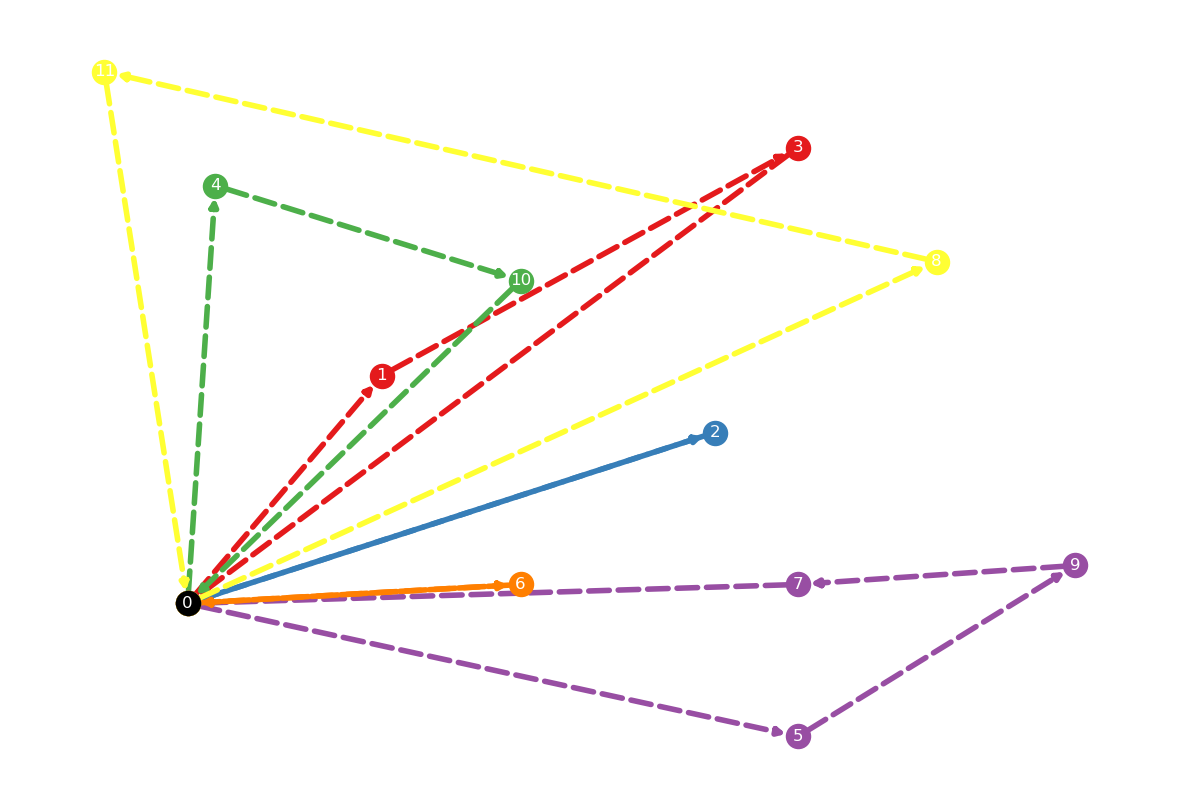

In [170]:
#| code-fold: true
#| label: fig-cvrp-two-index-sol
#| fig-cap: Optimal routes found by the two-index formulation

cvrp1 = Cvrp1(CvrpDataCenter())
cvrp1.read_instance("./data/cvrp/P-n16-k8-mini.vrp")
cvrp1.build_model()
cvrp1.show_model_summary()
cvrp1.optimize()
cvrp1.show_opt_routes()

It can be seen from the model output that there are a total of 32798 constraints, out of which 32767 are subtour elimination constraints, even for such a small instance with only 15 customers.
In the next section, we will present another two index formulation to handle this exponential number of constraints.

## Two-index Formulation - 2

This formulation is based on the MTZ-model introduced by @miller_integer_1960 for the TSP.
To eliminate subtours, a new variable $u_i$ is defined for every node $i \in \mathcal{N}$:

- $u_i$: the total demands distributed by any vehicle when it arrives at node $i$

\begin{align}
    \text{min.} &\quad \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ij} \label{cvrp2-obj} \\
    \text{s.t.} &\quad \sum_{j \in \delta^+(i)}x_{ij} = 1, \ \forall i \in \mathcal{N} \label
    {cvrp2-cons1}\\
    &\quad \sum_{i \in \delta^-(j)} x_{ij} = 1, \ \forall j \in \mathcal{N} \label{cvrp2-cons2} \\
    &\quad \sum_{j \in \delta^+(0)} x_{oj} = |\mathcal{K}| \label{cvrp2-cons3} \\
    &\quad u_i \leq u_j - q_j + Q(1 - x_{ij}), \ \forall (i, j) \in \mathcal{A}, i, j \in \mathcal{N} \label{cvrp2-cons4}\\
    &\quad q_i \leq u_i \leq Q, \ \forall i \in \mathcal{N} \label{cvrp2-cons5} \\
    &\quad x_{ij} \in \{0, 1\}, \ \forall (i, j) \in \mathcal{A} \label{cvrp2-cons6}
\end{align}

In [165]:
from ortools.linear_solver import pywraplp
from itertools import product
import numpy as np

class Cvrp2:
    """solve the cvrp model using the two index formulation
    """

    def __init__(self, cvrp_data_center: CvrpDataCenter):
        self._data_center: CvrpDataCenter = cvrp_data_center
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        self._var_u = None
        
        self._opt_obj = None
        self._opt_x = None
        self._opt_routes = None
    
    def read_instance(self, instance_file):
        self._data_center.read_cvrp_instance(instance_file)

    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_constr_flow()
        self._create_constr_fleet()
        self._create_constr_subtour()
        
    def optimize(self):
        status = self._solver.Solve()
        if not status:
            self._retrieve_opt_solution()
            self._retrieve_opt_routes()
    
    def _create_variables(self):
        num_nodes = self._data_center.num_nodes
        self._var_x = np.empty((num_nodes, num_nodes), dtype=object)
        for i, j in product(range(num_nodes), range(num_nodes)):
            if i == j: continue
            self._var_x[i][j] = self._solver.BoolVar(name="x_{i, j}")
            
        self._var_u = np.empty(num_nodes, dtype=object)
        nodes = self._data_center.nodes
        vehicle_capacity = float(self._data_center.vehicle_capacity)
        for node in nodes:
            if node.id == 0: continue
            self._var_u[node.id] = self._solver.NumVar(
                lb=float(node.demand), 
                ub=vehicle_capacity,
                name='v')

    def _create_objective(self):
        num_nodes = self._data_center.num_nodes
        obj_expr = [
            self._data_center.distance(i, j, integer=True) * 
                self._var_x[i][j]
                for i, j in product(range(num_nodes), range(num_nodes))
                if i != j
        ]
        self._solver.Minimize(self._solver.Sum(obj_expr))
            
    def _create_constr_flow(self):
        # create incoming and outgoing arc constraints
        num_nodes = self._data_center.num_nodes
        for i in range(1, num_nodes):
            out_arcs = [self._var_x[i][j] for j in range(num_nodes) if j != i]
            in_arcs = [self._var_x[j][i] for j in range(num_nodes) if j != i]
            self._solver.Add(self._solver.Sum(out_arcs) == 1)
            self._solver.Add(self._solver.Sum(in_arcs) == 1)
            
    def _create_constr_fleet(self):
        # create fleet size constraint
        num_nodes = self._data_center.num_nodes
        num_vehicles = self._data_center.num_vehicles
        expr = [self._var_x[0][i] for i in range(1, num_nodes)]
        self._solver.Add(self._solver.Sum(expr) == num_vehicles)
    
    def _create_constr_subtour(self):
        # create subtour elimination constraint
        constraints = []
        nodes = self._data_center.nodes
        vehicle_capacity = self._data_center.vehicle_capacity
        for ni, nj in product(nodes, nodes):
            if ni.id == 0 or nj.id == 0: continue
            if ni.id == nj.id: continue
            constr = self._solver.Add(
                self._var_u[ni.id] <=
                self._var_u[nj.id] -
                nj.demand +
                vehicle_capacity * (
                    1 - self._var_x[ni.id][nj.id]
                )
            )
            constraints.append(constr)

        print(f"No. subtour elimination constraints: {len(constraints)}")
    
    def show_model_summary(self):
        print(f"No. of variables: {self._solver.NumVariables()}")
        print(f"No. of constraints: {self._solver.NumConstraints()}")
    
    def _retrieve_opt_solution(self):
        self._opt_obj = self._solver.Objective().Value()
        print(f'Optimal value: {self._opt_obj:.2f}')
        
        num_nodes = self._data_center.num_nodes
        self._opt_x = np.zeros((num_nodes, num_nodes))
        for i, j in product(range(num_nodes), range(num_nodes)):
            if i == j: continue
            self._opt_x[i][j] = int(self._var_x[i][j].solution_value())

    def _retrieve_opt_routes(self):
        num_nodes = self._data_center.num_nodes
        self._routes = []
        for i in range(1, num_nodes):
            if self._opt_x[0][i] == 0: continue
            # new route found
            route = []
            
            route_length = 0
            # add the first arc
            arc_start = 0
            arc_end = i
            route.append((arc_start, arc_end))
            route_length += self._data_center\
                    .distance(arc_start, 
                            arc_end,
                            integer=True)
            
            # add remaining arcs on the route
            arc_start = arc_end
            while True:
                for j in range(num_nodes):
                    if self._opt_x[arc_start][j] == 1:
                        arc_end = j
                        break
                route.append((arc_start, arc_end))
                route_length += self._data_center\
                    .distance(arc_start,
                            arc_end,
                            integer=True)
                if arc_end == 0: break
                arc_start = arc_end

            self._routes.append(route)
            print(f'route: {route}, length: {route_length}')
    
    def show_opt_routes(self):
        nodes = self._data_center.nodes
        locations = {
            node.id: (node.x_coord, node.y_coord)
            for node in nodes
        }

        edges = []
        vehicle_idx = 0
        for route in self._routes:
            for arc in route:
                edges.append((arc[0], arc[1], {'vehicle': str(vehicle_idx)}))
            vehicle_idx += 1
        edges

        show_vehicle_routes(locations, edges)

No. subtour elimination constraints: 110
No. of variables: 143
No. of constraints: 133
Optimal value: 347.00
route: [(0, 1), (1, 3), (3, 0)], length: 66
route: [(0, 2), (2, 0)], length: 42
route: [(0, 5), (5, 9), (9, 7), (7, 0)], length: 68
route: [(0, 6), (6, 0)], length: 24
route: [(0, 10), (10, 4), (4, 0)], length: 55
route: [(0, 11), (11, 8), (8, 0)], length: 92


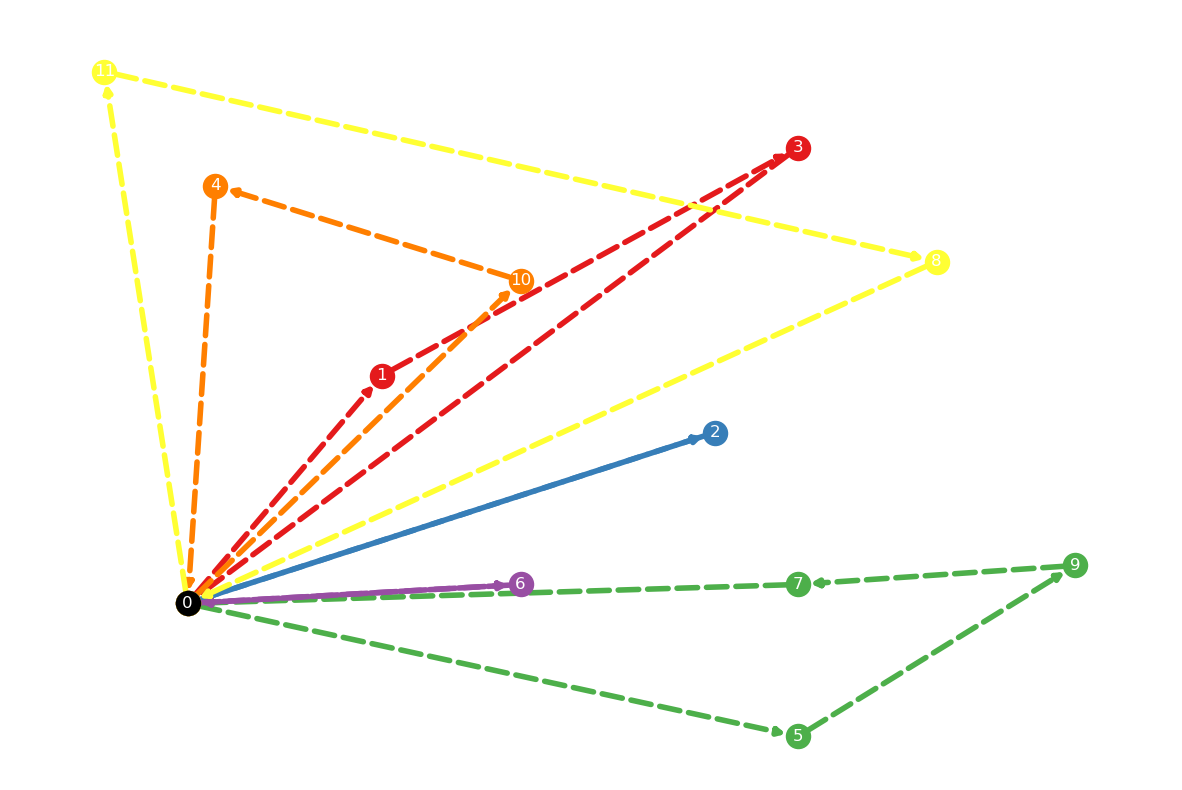

In [166]:
cvrp2 = Cvrp2(CvrpDataCenter())
cvrp2.read_instance("./data/cvrp/P-n16-k8-mini.vrp")
cvrp2.build_model()
cvrp2.show_model_summary()
cvrp2.optimize()
cvrp2.show_opt_routes()

## Three-index Formulation

This formulation is also known as the *MTZ-formulation* as a new set of constraints initially proposed for traveling salesman problem (@miller_integer_1960) is used to eliminate subtours.

We define the following variables in this formualation:

- $x_{ijk}$: a binary variable that equals 1 when the vehicle $k$ visits arc $(i, j) \in \mathcal{A}$, 0 otherwise
- $y_{ik}$: a binary variable that equals 1 if node $i$ is visited by vehicle $k$, 0 otherwise
- $u_{ik}$: a continuous variable that represents the demands delivered by vehicle $k$ when arriving at node $i$ 

\begin{align}
    \text{min.} &\quad \sum_{k \in \mathcal{K}} \sum_{(i, j) \in \mathcal{A}} c_{ij} x_{ijk} \label{cvrp3-obj} \\
    \text{s.t.} &\quad x_{iik} = 0, \ \forall i \in \mathcal{V}, k \in \mathcal{K} \\
    &\quad \sum_{j \in \mathcal{V}}x_{ijk} = \sum_{j \in \mathcal{V}}x_{jik}, \ \forall i \in \mathcal{V}, k \in \mathcal{K} \label{cvrp3-cons3} \\
    &\quad \sum_{k \in \mathcal{K}} y_{ik} = 1, \ \forall i \in \mathcal{N} \label{cvrp3-cons1} \\
    &\quad y_{ik} = \sum_{j \in \mathcal{V}} x_{ijk}, \ \forall i \in \mathcal{V}, k \in \mathcal{K} \label{cvrp3-cons4} \\
    &\quad y_{0k} = 1, \ \forall k \in \mathcal{K} \\
    &\quad u_{i} \leq u_{j} - q_j + Q(1 - x_{ijk}), \ \forall i \neq j, i, j \in \mathcal{N}, k \in \mathcal{K} \label{cvrp3-cons6} \\
    &\quad q_i \leq u_{i} \leq Q, \ \forall i \in \mathcal{N}\label{cvrp-cons7}\\
    &\quad x_{ijk} \in \{0, 1\}, \ \forall (i, j) \in \mathcal{A}, k \in \mathcal{K} \label{cvrp3-cons8} \\
    &\quad y_{ik} \in \{0, 1\}, \ \forall i \in \mathcal{V}, k \in \mathcal{K} \label{cvrp3-cons9} \\
    &\quad u_{ik} \geq 0, \ \forall i \in \mathcal{V}, k \in \mathcal{K} \label{cvrp3-cons10}
\end{align}

In [159]:
from ortools.linear_solver import pywraplp
from itertools import product
import numpy as np

class Cvrp3:
    """solve the cvrp model using the two index formulation
    """

    def __init__(self, cvrp_data_center: CvrpDataCenter):
        self._data_center: CvrpDataCenter = cvrp_data_center
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        self._var_y = None
        self._var_u = None
        
        self._opt_obj = None
        self._opt_x = None
        self._opt_routes = None
    
    def read_instance(self, instance_file):
        self._data_center.read_cvrp_instance(instance_file)

    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_constr_flow()
        self._create_constr_customer_must_be_visited()
        self._create_constr_subtour()
        
    def optimize(self):
        status = self._solver.Solve()
        print("solve complete!")
        if not status:
            self._retrieve_opt_solution()
            self._retrieve_opt_routes()
        else:
            print(f"status={status}")
    
    def _create_variables(self):
        num_nodes = self._data_center.num_nodes
        num_vehicles = self._data_center.num_vehicles
        self._var_x = np.empty((num_vehicles, num_nodes, num_nodes), 
                            dtype=object)
        for k, i, j in product(range(num_vehicles), 
                            range(num_nodes),
                            range(num_nodes)):
            self._var_x[k][i][j] = self._solver.BoolVar(name=f"x_{k, i, j}")
            
        self._var_y = np.empty((num_vehicles, num_nodes), dtype=object)
        for k, i in product(range(num_vehicles),
                            range(num_nodes)):
            self._var_y[k][i] = self._solver.BoolVar(name=f'y_{k, i}')
        
        vehicle_capacity = self._data_center.vehicle_capacity
        self._var_u = np.empty(num_nodes, dtype=object)
        for node in self._data_center.nodes:
            self._var_u[node.id] = self._solver.NumVar(
                float(node.demand),
                vehicle_capacity,
                name=f'u_{node.id}')

    def _create_objective(self):
        num_vehicles = self._data_center.num_vehicles
        num_nodes = self._data_center.num_nodes
        obj_expr = [
            self._data_center.distance(i, j, integer=True) * 
                self._var_x[k][i][j]
                for k, i, j in product(range(num_vehicles), range(num_nodes), range(num_nodes))
                if i != j
        ]
        self._solver.Minimize(self._solver.Sum(obj_expr))
    
    def _create_constr_flow(self):
        # create incoming and outgoing arc constraints
        num_vehicles = self._data_center.num_vehicles
        num_nodes = self._data_center.num_nodes
        for k, i in product(range(num_vehicles),
                            range(num_nodes)):
            self._solver.Add(self._var_x[k][i][i] == 0)
            
        for k, i in product(range(num_vehicles),
                            range(num_nodes)):
            expr1 = [self._var_x[k][i][j] for j in range(num_nodes)]
            expr2 = [self._var_x[k][j][i] for j in range(num_nodes)]
            self._solver.Add(self._solver.Sum(expr1) == 
                            self._solver.Sum(expr2))
    
    def _create_constr_customer_must_be_visited(self):
        num_vehicles = self._data_center.num_vehicles
        num_nodes = self._data_center.num_nodes
        for i in range(1, num_nodes):
            expr = [self._var_y[k][i] for k in range(num_vehicles)]
            self._solver.Add(self._solver.Sum(expr) == 1)
        
        for k, i in product(range(num_vehicles),
                            range(num_nodes)):
            expr = [self._var_x[k][i][j] for j in range(num_nodes)]
            self._solver.Add(self._solver.Sum(expr) ==
                            self._var_y[k][i])
        
        for k in range(num_vehicles):
            self._solver.Add(self._var_y[k][0] == 1)

    def _create_constr_subtour(self):
        # create subtour elimination constraint
        constraints = []
        nodes = self._data_center.nodes
        vehicle_capacity = self._data_center.vehicle_capacity
        num_vehicles = self._data_center.num_vehicles
        for k, ni, nj in product(range(num_vehicles), nodes, nodes):
            if ni.id == 0 or nj.id == 0: continue
            if ni.id == nj.id: continue
            constr = self._solver.Add(self._var_u[ni.id] <=
                    self._var_u[nj.id] -
                    float(nj.demand) +
                    vehicle_capacity * (
                        1 - self._var_x[k][ni.id][nj.id]
                    )
                )
            constraints.append(constr)

        print(f"No. subtour elimination constraints: {len(constraints)}")
    
    def show_model_summary(self):
        print(f"No. of variables: {self._solver.NumVariables()}")
        print(f"No. of constraints: {self._solver.NumConstraints()}")
    
    def _retrieve_opt_solution(self):
        self._opt_obj = self._solver.Objective().Value()
        print(f'Optimal value: {self._opt_obj:.2f}')
        
        num_nodes = self._data_center.num_nodes
        num_vehicles = self._data_center.num_vehicles
        self._opt_x = np.zeros((num_vehicles, num_nodes, num_nodes))
        for k, i, j in product(range(num_vehicles), range(num_nodes), range(num_nodes)):
            self._opt_x[k][i][j] = int(self._var_x[k][i][j].solution_value())

    def _retrieve_opt_routes(self):
        num_nodes = self._data_center.num_nodes
        num_vehicles = self._data_center.num_vehicles
        self._routes = []
        for k in range(num_vehicles):     
            route = []   
            for i in range(1, num_nodes):
                if self._opt_x[k][0][i] == 0: continue

                # new route found
                route_length = 0
                # add the first arc
                arc_start = 0
                arc_end = i
                route.append((arc_start, arc_end))
                route_length += self._data_center\
                        .distance(arc_start, 
                                arc_end,
                                integer=True)
                
                # add remaining arcs on the route
                arc_start = arc_end
                while True:
                    for j in range(num_nodes):
                        if self._opt_x[k][arc_start][j] == 1:
                            arc_end = j
                            break
                    route.append((arc_start, arc_end))
                    route_length += self._data_center\
                        .distance(arc_start,
                                arc_end,
                                integer=True)
                    if arc_end == 0: break
                    arc_start = arc_end

                self._routes.append(route)
                print(f'route: {route}, length: {route_length}')
                
                break
    
    def show_opt_routes(self):
        nodes = self._data_center.nodes
        locations = {
            node.id: (node.x_coord, node.y_coord)
            for node in nodes
        }

        edges = []
        vehicle_idx = 0
        for route in self._routes:
            for arc in route:
                edges.append((arc[0], arc[1], {'vehicle': str(vehicle_idx)}))
            vehicle_idx += 1
        edges

        show_vehicle_routes(locations, edges)

No. subtour elimination constraints: 660
No. of variables: 948
No. of constraints: 893
solve complete!
Optimal value: 347.00
route: [(0, 3), (3, 1), (1, 0)], length: 66
route: [(0, 2), (2, 0)], length: 42
route: [(0, 7), (7, 9), (9, 5), (5, 0)], length: 68
route: [(0, 8), (8, 11), (11, 0)], length: 92
route: [(0, 4), (4, 10), (10, 0)], length: 55
route: [(0, 6), (6, 0)], length: 24


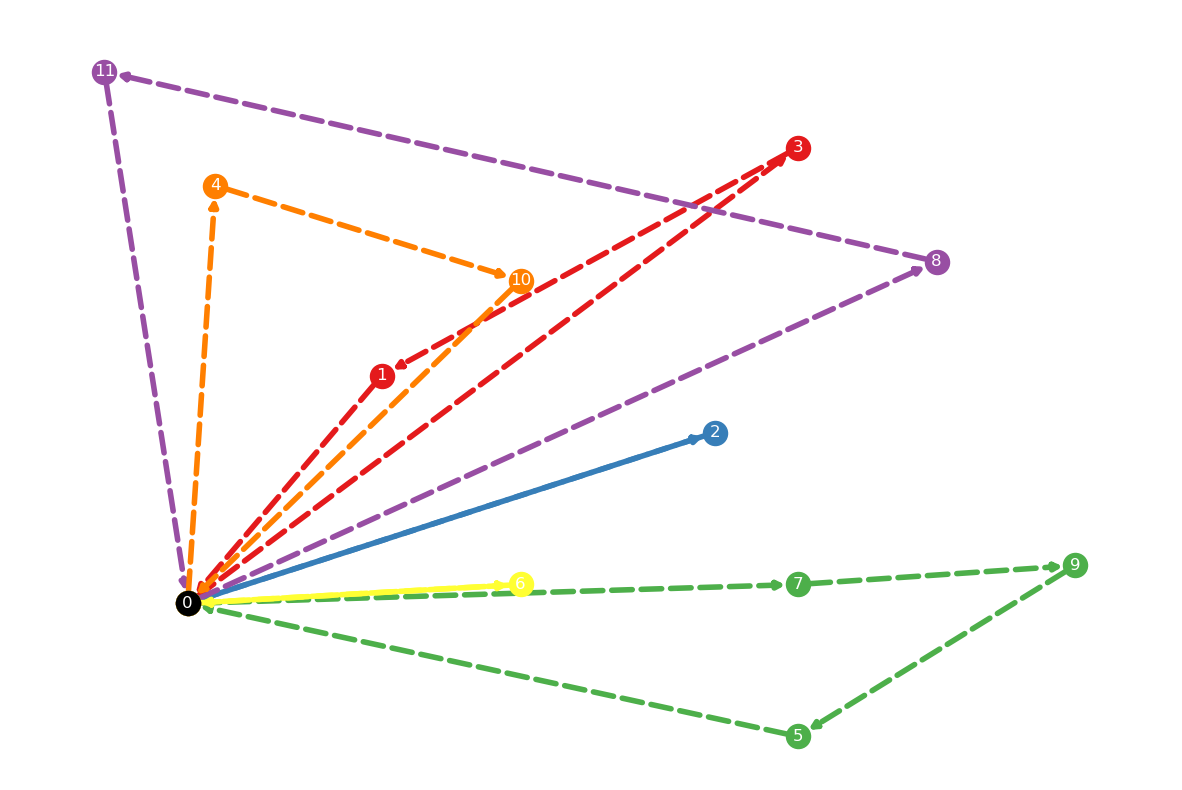

In [160]:
cvrp3 = Cvrp3(CvrpDataCenter())
cvrp3.read_instance("./data/cvrp/P-n16-k8-mini.vrp")
cvrp3.build_model()
cvrp3.show_model_summary()
cvrp3.optimize()
cvrp3.show_opt_routes()

In [ ]:
#| echo: false

# cvrp3 = Cvrp3(CvrpDataCenter())

# cvrp3.read_instance("./data/cvrp/E-n13-k4.vrp")
# cvrp3._data_center._distance = [
#     [0,   9, 14, 23, 32, 50, 21, 49, 30, 27, 35, 28, 18],
#     [9,   0, 21, 22, 36, 52, 24, 51, 36, 37, 41, 30, 20], 
#     [14, 21,  0, 25, 38,  5, 31,  7, 36, 43, 29,  7,  6], 
#     [23, 22, 25,  0, 42, 12, 35, 17, 44, 31, 31, 11,  6], 
#     [32, 36, 38, 42,  0, 22, 37, 16, 46, 37, 29, 13, 14], 
#     [50, 52,  5, 12, 22,  0, 41, 23, 10, 39,  9, 17, 16], 
#     [21, 24, 31, 35, 37, 41,  0, 26, 21, 19, 10, 25, 12], 
#     [49, 51,  7, 17, 16, 23, 26,  0, 30, 28, 16, 27, 12], 
#     [30, 36, 36, 44, 46, 10, 21, 30,  0, 25, 22, 10, 20], 
#     [27, 37, 43, 31, 37, 39, 19, 28, 25,  0, 20, 16,  8], 
#     [35, 41, 29, 31, 29,  9, 10, 16, 22, 20,  0, 10, 10], 
#     [28, 30,  7, 11, 13, 17, 25, 27, 10, 16, 10,  0, 10], 
#     [18, 20,  6,  6, 14, 16, 12, 12, 20,  8, 10, 10,  0] ]
# cvrp3.build_model()
# cvrp3.show_model_summary()
# cvrp3.optimize()
# cvrp3.show_opt_routes()

## Performance Comparison

@tbl-vrp-data shows the runtime comparison on the same instance.

In [174]:
# | echo: false
# | label: tbl-vrp-data
# | tbl-cap: Computational time comparison of the three formulations

from IPython.display import Markdown
from tabulate import tabulate

row_names = ["burma14"]
col_names = ["Instance", "Model 1", "Model 2", "Model 3"]

vrp_table_data = []

# add times for instance berma14
row_data = []
row_data.append('P-n12-k8-mini.vrp')
row_data.append('0.4s')
row_data.append('0.3s')
row_data.append('1m5s')
vrp_table_data.append(row_data)

Markdown(tabulate(vrp_table_data, headers=col_names))

Instance           Model 1    Model 2    Model 3
-----------------  ---------  ---------  ---------
P-n12-k8-mini.vrp  0.4s       0.3s       1m5s